In [ ]:
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import Phrases
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('stopwords')

import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load Corpus

In [ ]:
#load folders of documents from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#read in copus
corpus_root = '/content/drive/MyDrive/10-k'
corpus = PlaintextCorpusReader(corpus_root, '.*')

In [ ]:
#number of documents
len(corpus.fileids())

690

In [ ]:
#turn the corpus to dataframe
rows = []
for filename in corpus.fileids():
  rows.append((filename, corpus.raw(filename)))

df = pd.DataFrame(rows, columns=['name', 'text'])
df.head()

,name,text
0,1.txt,We are a leading provider of technology-enable...
1,10.txt,"Golden Nugget Online Gaming, Inc. (formerly kn..."
2,100.txt,This annual report on Form 10-K contains forwa...
3,1001.txt,We are a global designer and manufacturer of h...
4,1002.txt,This Management’s Discussion and Analysis of F...


Load Financial Data

In [ ]:
tar = pd.read_excel('tar.xlsx')
con = pd.read_excel('controls.xlsx')

In [ ]:
tar20 = tar[tar['percent'] >= 20]
len(tar20)

345

In [ ]:
con20 = con[con['stake_20'] == 'yes']
len(con20)

345

In [ ]:
con20.head()

,Company,market_capitalization,year,net_income,c&e,id,stake_20,total_assets,total_liabilities,total_equity,current_assets,current_liabilities,long_term_debt,total_cash_st_investment,Industry Group,Industry Sector,Primary Industry Classification,long_term_liabilities,MTB,tobin_q,TDEBT,LTDEBT,CFIN,CNFIN,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28
0,"Stoneridge, Inc. (NYSE:SRI)",816.4,lastest,-8.0,73.9,1001.0,yes,621.4,324.77,296.6,334.66,146.05,136,73.92,Automobiles and Components,Consumer Discretionary,Auto Parts and Equipment,178.72,2.752529,1.836450,1.094976,0.602562,0.249225,-0.243189,NaN,NaN,NaN,NaN,NaN
1,LCI Industries (NYSE:LCII),3262.0,lastest,158.4,51.8,1002.0,yes,2298,1389.71,908.3,869.80,416.39,720.42,51.82,Automobiles and Components,Consumer Discretionary,Auto Parts and Equipment,973.32,3.591324,2.024243,1.530012,1.071584,0.057052,-0.401376,NaN,NaN,NaN,NaN,NaN
2,Gentex Corporation (NasdaqGS:GNTX),8314.8,lastest,347.6,423.4,1003.0,yes,2197.9,234.00,1963.9,979.33,177.74,-,450.54,Automobiles and Components,Consumer Discretionary,Auto Parts and Equipment,56.26,4.233820,3.889531,0.119151,0.028647,0.229411,0.138907,NaN,NaN,NaN,AVG,STD
3,Cooper-Standard Holdings Inc. (NYSE:CPS),585.8,lastest,-267.6,438.4,1004.0,yes,2611.9,1987.83,624.1,1259.73,671.28,956.61,438.44,Automobiles and Components,Consumer Discretionary,Auto Parts and Equipment,1316.55,0.938632,0.985348,3.185115,2.109518,0.702516,-0.373081,NaN,NaN,MTB,-38.7195,806.125
4,"Thor Industries, Inc. (NYSE:THO)",5148.5,lastest,389.5,183.6,1005.0,yes,6369.5,3772.84,2596.7,2495.55,1672.41,1821.52,183.63,Automobiles and Components,Consumer Discretionary,Automobile Manufacturers,2100.43,1.982709,1.400634,1.452936,0.808884,0.070717,-0.573335,NaN,NaN,TDEBT,0.220408,36.5203


In [ ]:
tar20_df = tar20[['Company', 'id', 'tobin_q', 'TDEBT', 'LTDEBT', 'CFIN', 'CNFIN', 'Industry Sector']]
con20_df = con20[['Company', 'id', 'tobin_q', 'TDEBT', 'LTDEBT', 'CFIN', 'CNFIN', 'Industry Sector']]

In [ ]:
tar20_df['id'] = tar20_df['id'].apply(lambda x: int(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
con20_df['id'] = con20_df['id'].apply(lambda x: int(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tar20_df.head()

,Company,id,tobin_q,TDEBT,LTDEBT,CFIN,CNFIN,Industry Sector
0,"Echo Global Logistics, Inc. (NasdaqGS:ECHO)",1,1.450960,1.413570,0.469304,0.103405,-0.840861,Industrials
1,I-ON Digital Corp. (OTCPK:IONI),2,1.095455,0.415054,0.000000,0.568817,0.153763,Information Technology
2,"Five9, Inc. (NasdaqGM:FIVN)",3,11.931353,2.810100,2.439183,2.161676,1.790759,Information Technology
3,"Medallia, Inc. (NYSE:MDLA)",4,4.410966,1.757989,0.996124,1.342759,0.580893,Information Technology
4,"Cloudera, Inc.",5,2.057430,1.224107,0.636191,0.528761,-0.059154,Information Technology


In [ ]:
con20_df.head()

,Company,id,tobin_q,TDEBT,LTDEBT,CFIN,CNFIN,Industry Sector
0,"Stoneridge, Inc. (NYSE:SRI)",1001,1.836450,1.094976,0.602562,0.249225,-0.243189,Consumer Discretionary
1,LCI Industries (NYSE:LCII),1002,2.024243,1.530012,1.071584,0.057052,-0.401376,Consumer Discretionary
2,Gentex Corporation (NasdaqGS:GNTX),1003,3.889531,0.119151,0.028647,0.229411,0.138907,Consumer Discretionary
3,Cooper-Standard Holdings Inc. (NYSE:CPS),1004,0.985348,3.185115,2.109518,0.702516,-0.373081,Consumer Discretionary
4,"Thor Industries, Inc. (NYSE:THO)",1005,1.400634,1.452936,0.808884,0.070717,-0.573335,Consumer Discretionary


Corpus Prepossessing

In [ ]:
tar20_df['Industry Sector'].unique()

array(['Industrials', 'Information Technology', 'Consumer Discretionary',
       'Health Care', 'Materials', 'Real Estate', 'Utilities', 'Energy',
       'Consumer Staples', 'Communication Services'], dtype=object)

In [ ]:
tar20_df[tar20_df['Industry Sector'] == 'Consumer Discretionary'].head()

,Company,id,tobin_q,TDEBT,LTDEBT,CFIN,CNFIN,Industry Sector
6,"Veoneer, Inc. (NYSE:VNE)",7,1.450306,0.846651,0.372881,0.611784,0.138015,Consumer Discretionary
9,"Golden Nugget Online Gaming, Inc. (NasdaqGM:GNOG)",10,5.588640,-1.718785,-1.396782,-0.313194,0.008809,Consumer Discretionary
34,Stamps.com Inc.,35,3.041147,0.331773,0.095565,0.455343,0.219136,Consumer Discretionary
37,Allied Esports Entertainment Inc. (NasdaqCM:AESE),38,2.314863,0.852994,0.084731,0.012575,-0.755689,Consumer Discretionary
38,"Vinco Ventures, Inc. (NasdaqCM:BBIG)",39,1.303929,1.074815,0.238519,0.097778,-0.738519,Consumer Discretionary


In [ ]:
noise = ['transportation', 'ship', 'account', 'standards', 'asc', 'consolidate', 'audit', 'energy', 'plant', 'gaap', 'inc', 'cloud', 'software',
         'research', 'automotive', 'properties', 'real', 'estate', 'tenant', 'inventory', 'franchise', 'goodwill', 'license', 'asu', 'oil', 'gas',
         'clinical', 'healthcare', 'medical', 'gas', 'fuel', 'mine', 'electric', 'electricity', 'coal', 'vs', 'hundred', 'thousand', 'million', 
         'billions', 'billions', 'retail', 'ton', 'volumes', 'volume', 'fasb', 'ton', 'january', 'february', 'march', 'april', 'may', 'june', 'july',
         'august', 'september', 'october', 'november', 'december', 'fiscal']

In [ ]:
#create stopwords
stop_words = stopwords.words('english')
stop_words.extend(noise)

In [ ]:
#lemmatize
def token_lemmatize(token):
  return WordNetLemmatizer().lemmatize(token, pos='v')

#preprocess: tokenize, create bigrams, and lemmatize.
def preprocessing(text):
  text = simple_preprocess(text)
  nonstop = [word for word in text if word not in stop_words]
  bigram = gensim.models.Phrases(nonstop, min_count=5, threshold=100)
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  bigram_text = bigram_mod[nonstop]
  result = [token_lemmatize(word) for word in bigram_text]
  return result

In [ ]:
preprocessing('noses')

['nose']

In [ ]:
all_corpus = []
for i in range(len(df)):
  mda = preprocessing(df.iloc[i]['text'])
  all_corpus.append(mda)

In [ ]:
id2word = gensim.corpora.Dictionary(all_corpus)
id2word.filter_extremes(no_below=10, no_above=0.3)
train_corpus = [id2word.doc2bow(text) for text in all_corpus]

Topic Modeling on all corpus

In [ ]:
#select number of topics
#for k in [5, 10, 15, 20]:
#  lda_model = gensim.models.ldamodel.LdaModel(corpus=train_corpus, id2word=id2word, num_topics=k, random_state=100, chunksize=100)
#  coherenceM = CoherenceModel(model=lda_model, texts = all_corpus, dictionary=id2word, coherence='c_v')
#  print(k, coherenceM.get_coherence())

In [ ]:
ldaModel = gensim.models.ldamodel.LdaModel(corpus=train_corpus, id2word=id2word, num_topics=10, random_state=100, chunksize=100)

In [ ]:
ldaModel.print_topics(num_words=15)

[(0,
  '0.029*"power" + 0.018*"mine" + 0.014*"idaho" + 0.012*"study" + 0.012*"plant" + 0.011*"water" + 0.010*"reclamation" + 0.010*"joint" + 0.009*"bond" + 0.009*"treatment" + 0.008*"mortgage" + 0.008*"approval" + 0.008*"pad" + 0.007*"tons" + 0.007*"venture"'),
 (1,
  '0.054*"natural" + 0.017*"drill" + 0.016*"prove" + 0.016*"commodity" + 0.014*"crude" + 0.013*"exploration" + 0.010*"gather" + 0.010*"trust" + 0.010*"depletion" + 0.009*"ngl" + 0.009*"partnership" + 0.008*"mcf" + 0.008*"basin" + 0.008*"royalty" + 0.008*"boe"'),
 (2,
  '0.022*"covid" + 0.014*"care" + 0.013*"pandemic" + 0.009*"train" + 0.008*"fy" + 0.008*"china" + 0.007*"europe" + 0.006*"backlog" + 0.005*"warranty" + 0.005*"millions" + 0.005*"surgical" + 0.005*"asia" + 0.005*"patient" + 0.005*"defense" + 0.004*"industrial"'),
 (3,
  '0.060*"store" + 0.021*"venture" + 0.018*"joint" + 0.018*"square" + 0.011*"merchandise" + 0.011*"noi" + 0.011*"restaurant" + 0.010*"ffo" + 0.010*"rental" + 0.009*"foot" + 0.009*"occupancy" + 0.00

LDA for target MDA

In [ ]:
def find_id(s):
  return int(''.join(x for x in s if x.isdigit()))

In [ ]:
df['id'] = df['name'].apply(find_id)

In [ ]:
#tar_df = df[df['id'] < 1000] 

In [ ]:
#tar_corpus = []
#for i in range(len(tar_df)):
#  mda = tar_df.iloc[i]['text']
#  tar_corpus.append(preprocessing(mda))

In [ ]:
#id2word_tar = gensim.corpora.Dictionary(tar_corpus)
#id2word_tar.filter_extremes(no_below=10, no_above=0.35)
#train_corpus_tar = [id2word_tar.doc2bow(text) for text in tar_corpus]

In [ ]:
#for k in [5, 8, 10]:
#  lda_model_tar = gensim.models.ldamodel.LdaModel(corpus=train_corpus_tar, id2word=id2word_tar, num_topics=k, random_state=100, chunksize=100)
#  coherenceM = CoherenceModel(model=lda_model_tar, texts = tar_corpus, dictionary=id2word_tar, coherence='c_v')
#  print(k, coherenceM.get_coherence())

In [ ]:
#for k in np.arange(15, 26):
#  lda_model_tar = gensim.models.ldamodel.LdaModel(corpus=train_corpus_tar, id2word=id2word_tar, num_topics=k, random_state=100, chunksize=100)
#  coherenceM = CoherenceModel(model=lda_model_tar, texts = tar_corpus, dictionary=id2word_tar, coherence='c_v')
#  print(k, coherenceM.get_coherence())

In [ ]:
#lda_tar = gensim.models.ldamodel.LdaModel(corpus=train_corpus_tar, id2word=id2word_tar, num_topics=5, random_state=100, chunksize=100)

In [ ]:
#lda_tar.print_topics(num_words=15)

General Dataset

In [ ]:
vecs = []
for i in range(len(df)):
  topics = ldaModel.get_document_topics(train_corpus[i], minimum_probability=0)
  topic_dist = [topics[i][1] for i in range(10)]
  vecs.append(topic_dist)

In [ ]:
vec0 = [vecs[i][0] for i in range(len(vecs))]
vec1 = [vecs[i][1] for i in range(len(vecs))]
vec2 = [vecs[i][2] for i in range(len(vecs))]
vec3 = [vecs[i][3] for i in range(len(vecs))]
vec4 = [vecs[i][4] for i in range(len(vecs))]
vec5 = [vecs[i][5] for i in range(len(vecs))]
vec6 = [vecs[i][6] for i in range(len(vecs))]
vec7 = [vecs[i][7] for i in range(len(vecs))]
vec8 = [vecs[i][8] for i in range(len(vecs))]
vec9 = [vecs[i][9] for i in range(len(vecs))]
#vec10 = [vecs[i][10] for i in range(len(vecs))]
#vec11 = [vecs[i][11] for i in range(len(vecs))]
#vec12 = [vecs[i][12] for i in range(len(vecs))]
#vec13 = [vecs[i][13] for i in range(len(vecs))]
#vec14 = [vecs[i][14] for i in range(len(vecs))]
#vec15 = [vecs[i][15] for i in range(len(vecs))]
#vec16 = [vecs[i][16] for i in range(len(vecs))]
#vec17 = [vecs[i][17] for i in range(len(vecs))]
#vec18 = [vecs[i][18] for i in range(len(vecs))]
#vec19 = [vecs[i][19] for i in range(len(vecs))]

In [ ]:
df['topic0'] = vec0
df['topic1'] = vec1
df['topic2'] = vec2
df['topic3'] = vec3
df['topic4'] = vec4
df['topic5'] = vec5
df['topic6'] = vec6
df['topic7'] = vec7
df['topic8'] = vec8
df['topic9'] = vec9
#df['topic10'] = vec10
#df['topic11'] = vec11
#df['topic12'] = vec12
#df['topic13'] = vec13
#df['topic14'] = vec14
#df['topic15'] = vec15
#df['topic16'] = vec16
#df['topic17'] = vec17
#df['topic18'] = vec18
#df['topic19'] = vec19

In [ ]:
df.head()

,name,text,id,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,1.txt,We are a leading provider of technology-enable...,1,0.037965,0.000154,0.324757,0.000154,0.000154,0.000154,0.014974,0.000154,0.000154,0.621379
1,10.txt,"Golden Nugget Online Gaming, Inc. (formerly kn...",10,0.077490,0.000182,0.000182,0.000182,0.000182,0.000182,0.817318,0.039053,0.025815,0.039413
2,100.txt,This annual report on Form 10-K contains forwa...,100,0.215923,0.247327,0.000128,0.033299,0.000128,0.000128,0.000128,0.203728,0.000128,0.299083
3,1001.txt,We are a global designer and manufacturer of h...,1001,0.036671,0.500500,0.000098,0.110163,0.050129,0.000098,0.000098,0.000098,0.000098,0.302048
4,1002.txt,This Management’s Discussion and Analysis of F...,1002,0.000121,0.000121,0.027341,0.252942,0.255343,0.000121,0.000121,0.000121,0.000121,0.463647


In [ ]:
tar20_df['label'] = 1 #target company with label 1
con20_df['label'] = 0 #non-target company with lable 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
all_fin = pd.concat([tar20_df, con20_df])

In [ ]:
data = all_fin.merge(df, on = 'id')
data.head()

,Company,id,tobin_q,TDEBT,LTDEBT,CFIN,CNFIN,label,name,text,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,"Echo Global Logistics, Inc. (NasdaqGS:ECHO)",1,1.450960,1.413570,0.469304,0.103405,-0.840861,1,1.txt,We are a leading provider of technology-enable...,0.037965,0.000154,0.324757,0.000154,0.000154,0.000154,0.014974,0.000154,0.000154,0.621379
1,I-ON Digital Corp. (OTCPK:IONI),2,1.095455,0.415054,0.000000,0.568817,0.153763,1,2.txt,I-ON Digital Corp. (the “Company”) was incorpo...,0.426250,0.000500,0.000500,0.000500,0.000500,0.000500,0.104230,0.000500,0.021956,0.444564
2,"Five9, Inc. (NasdaqGM:FIVN)",3,11.931353,2.810100,2.439183,2.161676,1.790759,1,3.txt,We are a pioneer and leading provider of intel...,0.061185,0.000107,0.001874,0.000107,0.018107,0.002190,0.015161,0.000107,0.000107,0.901053
3,"Medallia, Inc. (NYSE:MDLA)",4,4.410966,1.757989,0.996124,1.342759,0.580893,1,4.txt,"Medallia, Inc. was founded in 2001 to help the...",0.012835,0.000113,0.002786,0.000113,0.000113,0.000113,0.000113,0.008501,0.000113,0.975198
4,"Cloudera, Inc.",5,2.057430,1.224107,0.636191,0.528761,-0.059154,1,5.txt,"At Cloudera, we believe that data can make wha...",0.000170,0.000170,0.000170,0.000170,0.062088,0.000170,0.100498,0.000170,0.002736,0.833660


Dimentional Reduction

In [ ]:
text_vec = data[['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9']]

In [ ]:
reduced_text = TSNE(n_components=2, perplexity=30, verbose=2, method='barnes_hut').fit_transform(text_vec)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 690 samples in 0.002s...
[t-SNE] Computed neighbors for 690 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 690 / 690
[t-SNE] Mean sigma: 0.163178
[t-SNE] Computed conditional probabilities in 0.039s
[t-SNE] Iteration 50: error = 62.9791298, gradient norm = 0.4032980 (50 iterations in 0.276s)
[t-SNE] Iteration 100: error = 61.7540054, gradient norm = 0.4136854 (50 iterations in 0.261s)
[t-SNE] Iteration 150: error = 61.5296860, gradient norm = 0.4041511 (50 iterations in 0.274s)
[t-SNE] Iteration 200: error = 61.7780800, gradient norm = 0.4033259 (50 iterations in 0.283s)
[t-SNE] Iteration 250: error = 61.3663826, gradient norm = 0.3971591 (50 iterations in 0.257s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.366383
[t-SNE] Iteration 300: error = 0.6346600, gradient norm = 0.0008027 (50 iterations in 0.194s)
[t-SNE] Iteration 350: error = 0.5876803, gradient norm = 0.0010788 (

In [ ]:
text2d_0 = [reduced_text[i][0] for i in range(690)]
text2d_1 = [reduced_text[i][1] for i in range(690)]
data['text2d_0'] = text2d_0
data['text2d_1'] = text2d_1

In [ ]:
all_vec = data[['tobin_q', 'TDEBT', 'LTDEBT', 'CFIN', 'CNFIN', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9']]
reduced_all = TSNE(n_components=2, perplexity=30, verbose=2, method='barnes_hut').fit_transform(all_vec)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 690 samples in 0.002s...
[t-SNE] Computed neighbors for 690 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 690 / 690
[t-SNE] Mean sigma: 0.670842
[t-SNE] Computed conditional probabilities in 0.033s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Iteration 50: error = 61.5508270, gradient norm = 0.4331400 (50 iterations in 0.289s)
[t-SNE] Iteration 100: error = 60.2638512, gradient norm = 0.4117782 (50 iterations in 0.282s)
[t-SNE] Iteration 150: error = 59.4969177, gradient norm = 0.4188206 (50 iterations in 0.279s)
[t-SNE] Iteration 200: error = 59.5527039, gradient norm = 0.4275250 (50 iterations in 0.286s)
[t-SNE] Iteration 250: error = 60.1745148, gradient norm = 0.4078336 (50 iterations in 0.255s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.174515
[t-SNE] Iteration 300: error = 0.6146168, gradient norm = 0.0019902 (50 iterations in 0.234s)
[t-SNE] Iteration 350: error = 0.5648079, gradient norm = 0.0003135 (50 iterations in 0.209s)
[t-SNE] Iteration 400: error = 0.5550575, gradient norm = 0.0002062 (50 iterations in 0.212s)
[t-SNE] Iteration 450: error = 0.5507780, gradient norm = 0.0001574 (50 iterations in 0.212s)
[t-SNE] Iteration 500: error = 0.5486435, gradient norm = 0.0001383 (50 

In [ ]:
all2d_0 = [reduced_all[i][0] for i in range(690)]
all2d_1 = [reduced_all[i][1] for i in range(690)]
data['all2d_0'] = all2d_0
data['all2d_1'] = all2d_1

In [ ]:
data.head()

,Company,id,tobin_q,TDEBT,LTDEBT,CFIN,CNFIN,label,name,text,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,text2d_0,text2d_1,all2d_0,all2d_1
0,"Echo Global Logistics, Inc. (NasdaqGS:ECHO)",1,1.450960,1.413570,0.469304,0.103405,-0.840861,1,1.txt,We are a leading provider of technology-enable...,0.000094,0.321605,0.012691,0.000094,0.000094,0.571907,0.000094,0.024085,0.000094,0.069242,-6.445950,-12.685161,1.144665,-19.206360
1,I-ON Digital Corp. (OTCPK:IONI),2,1.095455,0.415054,0.000000,0.568817,0.153763,1,2.txt,I-ON Digital Corp. (the “Company”) was incorpo...,0.022872,0.000330,0.000330,0.411439,0.172695,0.381204,0.000330,0.010139,0.000330,0.000330,1.663412,-4.977903,-17.651590,-6.887510
2,"Five9, Inc. (NasdaqGM:FIVN)",3,11.931353,2.810100,2.439183,2.161676,1.790759,1,3.txt,We are a pioneer and leading provider of intel...,0.000072,0.000072,0.000072,0.126429,0.169215,0.309350,0.000072,0.394573,0.000072,0.000072,-2.813393,0.685834,6.696180,32.050213
3,"Medallia, Inc. (NYSE:MDLA)",4,4.410966,1.757989,0.996124,1.342759,0.580893,1,4.txt,"Medallia, Inc. was founded in 2001 to help the...",0.000072,0.000072,0.000072,0.208982,0.010598,0.192717,0.000072,0.587273,0.000072,0.000072,-1.328391,4.687215,5.039080,13.832593
4,"Cloudera, Inc.",5,2.057430,1.224107,0.636191,0.528761,-0.059154,1,5.txt,"At Cloudera, we believe that data can make wha...",0.042241,0.000111,0.000111,0.052358,0.100649,0.184119,0.000111,0.620080,0.000111,0.000111,-2.971295,5.055832,-2.322443,-0.520234


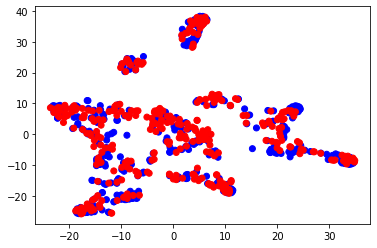

In [ ]:
#red for non-target; blue for target
colormap_1 = np.array(['red', 'blue'])
plt.scatter(data['text2d_0'], data['text2d_1'], c = colormap_1[data['label']])

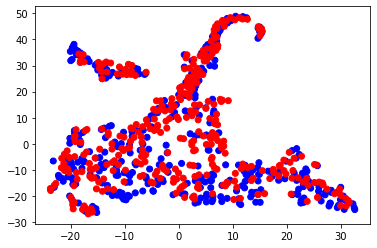

In [ ]:
#red for non-target; blue for target
colormap_2 = np.array(['red', 'blue'])
plt.scatter(data['all2d_0'], data['all2d_1'], c = colormap_2[data['label']])

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#Logistic Regression on finantial ratios
X=data[['tobin_q', 'TDEBT', 'LTDEBT', 'CFIN', 'CNFIN']]
y=data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
lg_cm = confusion_matrix(y_test, y_pred)

acc = (lg_cm[0, 0] + lg_cm[1, 1]) / len(X_test)
recall = lg_cm[0, 0] / (lg_cm[0, 0] + lg_cm[0, 1])
precision = lg_cm[0, 0] / (lg_cm[0, 0] + lg_cm[1, 0])
acc, recall, precision

(0.5942028985507246, 0.4807692307692308, 0.625)

In [ ]:
#Logistic Regression on topic distributions
X=data[['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9']]
y=data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
lg = LogisticRegression(max_iter=500)
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
lg_cm = confusion_matrix(y_test, y_pred)

acc = (lg_cm[0, 0] + lg_cm[1, 1]) / len(X_test)
recall = lg_cm[0, 0] / (lg_cm[0, 0] + lg_cm[0, 1])
precision = lg_cm[0, 0] / (lg_cm[0, 0] + lg_cm[1, 0])
acc, recall, precision

(0.5893719806763285, 0.6153846153846154, 0.5871559633027523)

In [ ]:
#Logistic Regression on financial & topic features
X=data[['tobin_q', 'TDEBT', 'LTDEBT', 'CFIN', 'CNFIN', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9']]
y=data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
lg = LogisticRegression(max_iter = 500)
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
lg_cm = confusion_matrix(y_test, y_pred)

acc = (lg_cm[0, 0] + lg_cm[1, 1]) / len(X_test)
recall = lg_cm[0, 0] / (lg_cm[0, 0] + lg_cm[0, 1])
precision = lg_cm[0, 0] / (lg_cm[0, 0] + lg_cm[1, 0])
acc, recall, precision

(0.5942028985507246, 0.6057692307692307, 0.5943396226415094)

SVM

In [ ]:
from sklearn import svm

In [ ]:
#SVM on financial ratios
X=data[['tobin_q', 'TDEBT', 'LTDEBT', 'CFIN', 'CNFIN']]
y=data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)
svm_cm = confusion_matrix(y_test, y_pred)

acc = (svm_cm[0, 0] + svm_cm[1, 1]) / len(X_test)
recall = svm_cm[0, 0] / (svm_cm[0, 0] + svm_cm[0, 1])
precision = svm_cm[0, 0] / (svm_cm[0, 0] + svm_cm[1, 0])
acc, recall, precision

(0.5845410628019324, 0.4519230769230769, 0.618421052631579)

In [ ]:
#SVM on topic distributions
X=data[['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9']]
y=data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)
svm_cm = confusion_matrix(y_test, y_pred)

acc = (svm_cm[0, 0] + svm_cm[1, 1]) / len(X_test)
recall = svm_cm[0, 0] / (svm_cm[0, 0] + svm_cm[0, 1])
precision = svm_cm[0, 0] / (svm_cm[0, 0] + svm_cm[1, 0])
acc, recall, precision

(0.5314009661835749, 0.5384615384615384, 0.5333333333333333)

In [ ]:
#SVM on financial ratios & topic distributions
X=data[['tobin_q', 'TDEBT', 'LTDEBT', 'CFIN', 'CNFIN', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9']]
y=data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)
svm_cm = confusion_matrix(y_test, y_pred)

acc = (svm_cm[0, 0] + svm_cm[1, 1]) / len(X_test)
recall = svm_cm[0, 0] / (svm_cm[0, 0] + svm_cm[0, 1])
precision = svm_cm[0, 0] / (svm_cm[0, 0] + svm_cm[1, 0])
acc, recall, precision

(0.5555555555555556, 0.5865384615384616, 0.5545454545454546)

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
#Decision Tree on financial ratios
X=data[['tobin_q', 'TDEBT', 'LTDEBT', 'CFIN', 'CNFIN']]
y=data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
clf_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf = 20, random_state=100)
clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
tree_cm = confusion_matrix(y_test, y_pred)

acc = (tree_cm[0, 0] + tree_cm[1, 1]) / len(X_test)
recall = tree_cm[0, 0] / (tree_cm[0, 0] + tree_cm[0, 1])
precision = tree_cm[0, 0] / (tree_cm[0, 0] + tree_cm[1, 0])
acc, recall, precision

(0.5893719806763285, 0.4807692307692308, 0.6172839506172839)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
tree.plot_tree(clf_tree, fontsize=10, feature_names=X.columns)

In [ ]:
#Decision Tree on topic distributions
X=data[['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9']]
y=data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
clf_tree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 20, random_state=100)
clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
tree_cm = confusion_matrix(y_test, y_pred)

acc = (tree_cm[0, 0] + tree_cm[1, 1]) / len(X_test)
recall = tree_cm[0, 0] / (tree_cm[0, 0] + tree_cm[0, 1])
precision = tree_cm[0, 0] / (tree_cm[0, 0] + tree_cm[1, 0])
acc, recall, precision

(0.5169082125603864, 0.7115384615384616, 0.5138888888888888)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
tree.plot_tree(clf_tree, fontsize=10, feature_names=X.columns)

In [ ]:
#Decision Tree on financial ratios & topic distributions
X=data[['tobin_q', 'TDEBT', 'LTDEBT', 'CFIN', 'CNFIN', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9']]
y=data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
clf_tree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 10, random_state=100)
clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
tree_cm = confusion_matrix(y_test, y_pred)

acc = (tree_cm[0, 0] + tree_cm[1, 1]) / len(X_test)
recall = tree_cm[0, 0] / (tree_cm[0, 0] + tree_cm[0, 1])
precision = tree_cm[0, 0] / (tree_cm[0, 0] + tree_cm[1, 0])
acc, recall, precision

(0.5410628019323671, 0.8653846153846154, 0.5263157894736842)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
tree.plot_tree(clf_tree, fontsize=10, feature_names=X.columns)